# Cluster Optimization with Silhouette Width

Determine the statistically optimal number of clusters with the silhouette width.

In [4]:
input_file = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/adata_subset_stripped.h5ad"
output_csv = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/clusters_silhouette_subset.csv"

In [6]:
suppressPackageStartupMessages({library(Seurat)})
srt = schard::h5ad2seurat(input_file)
srt[['RNA']]$data = as.matrix(schard::h5ad2Matrix(input_file, name = "/layers/log1p_norm_of_counts"))
stopifnot(!(all(srt[['RNA']]$data[1:50]%%1 == 0))) # check values (not integer)
names(srt@reductions) = c('diffmap', 'pca', 'tsne', 'umap')
srt

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.9 GiB”


An object of class Seurat 
11449 features across 22799 samples within 1 assay 
Active assay: RNA (11449 features, 0 variable features)
 2 layers present: counts, data
 4 dimensional reductions calculated: diffmap, pca, tsne, umap

## Multi-Resolution Clustering

We cluster the data across a range of candidate resolutions with the scMiko package.

In [ ]:
if (!"scMiko" %in% installed.packages()) {
    devtools::install_github(repo = "NMikolajewicz/scMiko")
}
suppressPackageStartupMessages({library(scMiko)})

resolutions <- seq(0.02, 0.5, by = 0.02)
mc.list <- multiCluster(object = srt, resolutions = resolutions, assay = 'RNA', nworkers = 16, pca_var = 0.9, group_singletons = F, algorithm = 1, return_object = F) # requires a lot of memory
# saveRDS(mc.list, output_file) # takes too long and is at least 10GB

Loading required package: parallel

Loading required package: foreach



2025-03-07 21:58:09.51721: Using 'RNA' assay for clustering...

2025-03-07 21:58:10.212764: Constructing nearest neighbor graph...

2025-03-07 21:58:19.398448: Clustering data...

2025-03-07 22:01:53.64971: Consolidating results...



These are all the computed clusterings.

scCustomize v3.0.1
If you find the scCustomize useful please cite.
See 'samuel-marsh.github.io/scCustomize/articles/FAQ.html' for citation info.



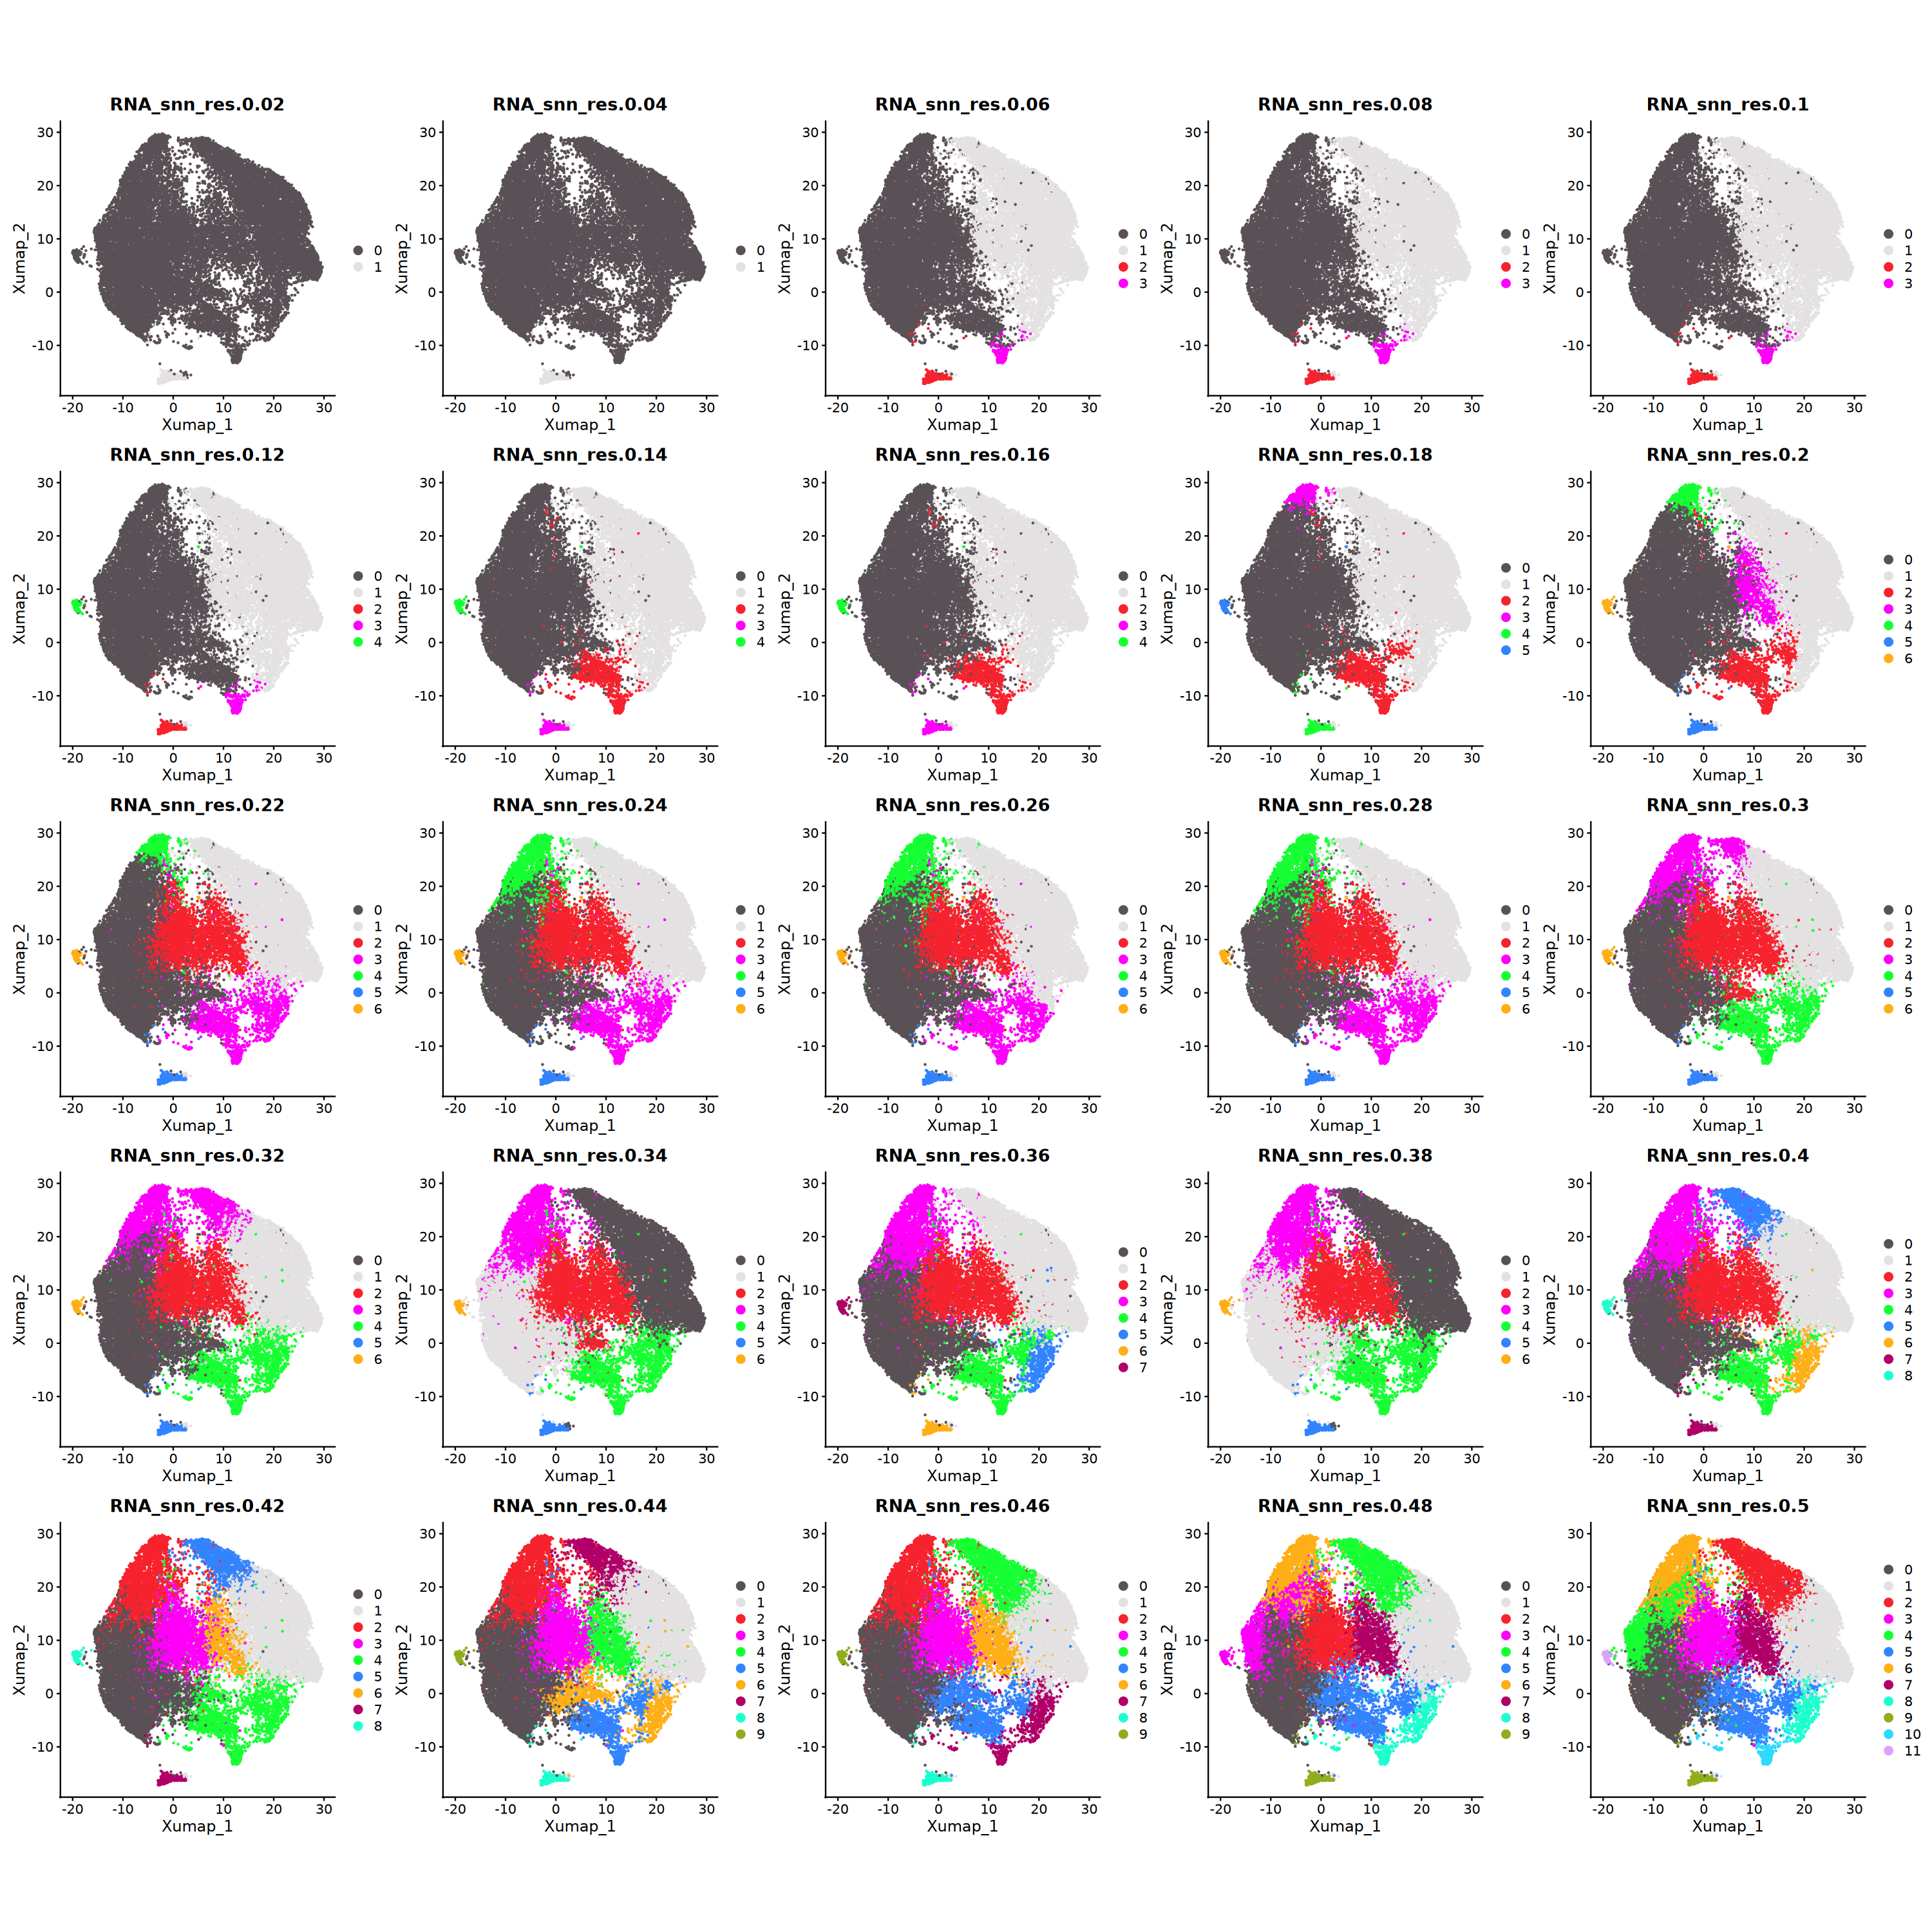

In [14]:
# unwrap results
plt.umap_by_cluster <- mc.list$plots
so.query <- mc.list$object
cr_names <- mc.list$resolution_names
cluster.name <- mc.list$cluster_names
assay.pattern <- mc.list$assay_pattern

# dimplot for all resolutions
library(scCustomize)
options(repr.plot.width = 25, repr.plot.height = 25)
DimPlot_scCustom(so.query, group.by = cluster.name, aspect_ratio = 1, num_columns = 5)

# Calculate Silhouette Width manually

The automatic way implemented in scMiko did only work on a subset of the data but not the full one. Hence, here we calculate the silhouette width manually.

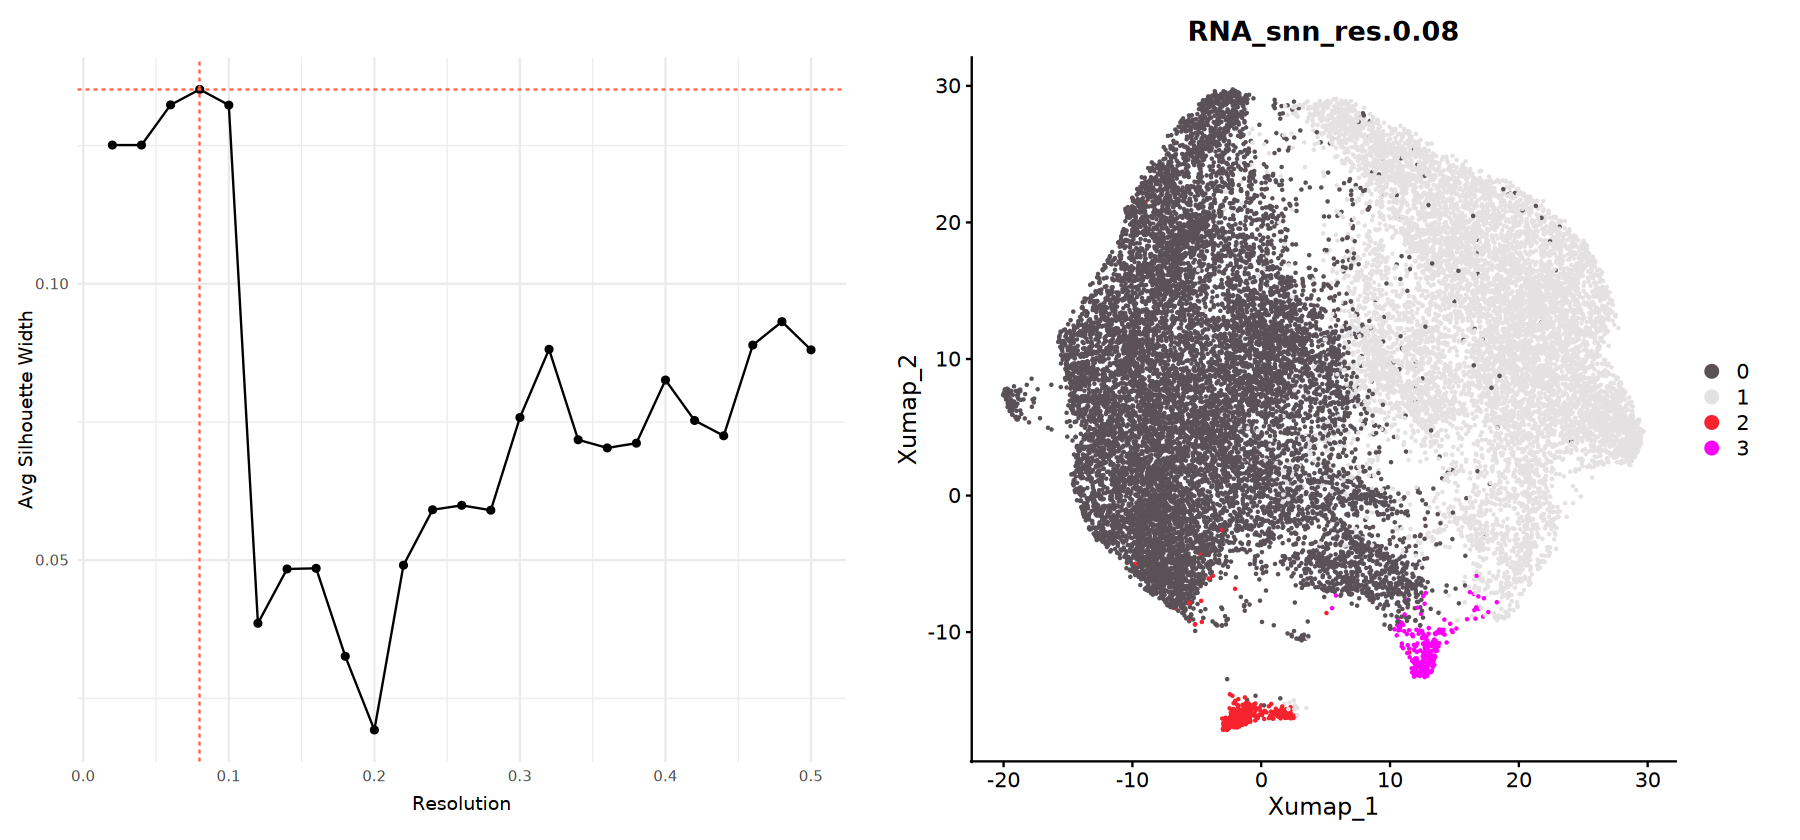

In [ ]:
library(cluster)
set.seed(123) # For reproducibility
embedding <- Embeddings(so.query, reduction = "pca")[, 1:10] # Use top 10 PCs
subset_indices <- sample(1:nrow(embedding), size = nrow(embedding) / 5)

silhouette_results <- list()
for (cls in cluster.name) {
    cat("Calculating silhouette width for ", cls, "\n")

    # Extract PCA or UMAP coordinates
    embedding <- Embeddings(so.query, reduction = "pca")[, 1:10] # Use top 10 PCs

    # Extract clustering assignments
    clusters <- so.query@meta.data[[cls]]

    # Subset embedding and clusters
    embedding_subset <- embedding[subset_indices, ]
    clusters_subset <- clusters[subset_indices]

    # Calculate silhouette
    silhouette_results[[cls]] <- silhouette(as.numeric(clusters_subset), dist(embedding_subset))
}

options(repr.plot.width = 7, repr.plot.height = 5)
df = data.frame(res = as.numeric(gsub("RNA_snn_res.", "", cluster.name)), avg_sil_width =  sapply(silhouette_results, function(x) mean(x[, "sil_width"])))
p1 = ggplot(data = df, aes(x = res, y = avg_sil_width)) +
        geom_line() +
        geom_point() +
        xlab("Resolution") +
        ylab("Avg Silhouette Width") +
        theme_minimal() +
        geom_hline(yintercept = max(df$avg_sil_width), linetype = "dashed", color = "tomato") +
        geom_vline(xintercept = as.numeric(df$res[which(df$avg_sil_width == max(df$avg_sil_width))]), linetype = "dashed", color = "tomato")

chosen_res = rownames(df)[which(df$avg_sil_width == max(df$avg_sil_width))]
p2 = DimPlot_scCustom(so.query, group.by = chosen_res, aspect_ratio = 1)

options(repr.plot.width = 15, repr.plot.height = 7)
p1 + p2

write.csv(so.query@meta.data[chosen_res], output_csv)